In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2
from haloclustering.models import Model
from haloclustering.data import get_combined_dataset
import haloclustering.evalulate_model as evaluate
import numpy as np
import matplotlib.pyplot as plt
import corner

# load in combined CGM$^2$ + CASBaH

In [2]:
cgmsqfile = "/Users/mwilde/python/cgm-squared/cgmsquared/data/cgm/cgmsquared_cgmsurvey_aodm_vhalos10_3sigma.json"
casdir = "/Users/mwilde/Dropbox/CASBaH/data/h1_galaxies_20Mpc_500kms_*.fits"
data = get_combined_dataset(cgmsqfile, casdir)

read_sets: Using set file -- 
  /Users/mwilde/python/linetools/linetools/lists/sets/llist_v1.3.ascii
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Cutting on redshift in hits/misses
Cutting on impact parameter in hits/misses
hits 1294
misses 4775
Cutting on redshift in hits/misses
Cutting on impact parameter in hits/misses
hits 268
misses 292


In [3]:
# r0, gamma, r0_2, gamma_2, beta1, beta2, beta2h, dndz_index, dndz_coeff = params

r_0 = 1 # clustering scale
r_0_2 = 4
beta_1_initial = 0.5
beta_2h_initial = 0.05
gamma_initial = 6 # clutering powerlaw index
gamma_2_initial = 1.6
dndz_index = 1.2 # dN/dz powerlaw index
dndz_coeff = 27
initial = np.array([r_0, gamma_initial, r_0_2, gamma_2_initial, beta_1_initial, beta_2h_initial, dndz_index, dndz_coeff])
bounds = ((0, 10), (0, 10), (0, 10), (0, 2), (-3, 3), (-3, 3), (-3, 3), (0, 35))

In [4]:
model = Model(data, m0=10**9.5)

In [5]:
soln = evaluate.max_likelihood_est(model, initial, bounds)
r0, gamma, r0_2, gamma_2, beta1, beta2h, dndz_index, dndz_coeff = soln.x

print('\n')
print("Maximum likelihood estimates:")
print("=============================")
print("r0 = {0:.3f}".format(r0))
print("r0_2 = {0:.3f}".format(r0_2))
print("gamma = {0:.3f}".format(gamma))
print("gamma_2 = {0:.3f}".format(gamma_2))
print("beta1 = {0:.3f}".format(beta1))
print("beta2h = {0:.3f}".format(beta2h))
print('dndz_index = {0:.3f}'.format(dndz_index))
print('dndz_index = {0:.3f}'.format(dndz_coeff))
print("=============================")

/Users/mwilde/python/cgm-squared/cgmsquared/clustering2.py:187: RuntimeWarning: divide by zero encountered in true_divide
  (x * (np.sqrt(r ** 2 + x ** 2) / r0) ** (-g))




Maximum likelihood estimates:
r0 = 1.627
r0_2 = 2.922
gamma = 2.248
gamma_2 = 1.086
beta1 = 0.158
beta2h = -0.067
dndz_index = 1.188
dndz_index = 26.972


In [6]:
model.params

array([ 1.62652908,  2.24806392,  2.92211758,  1.08616819,  0.1576173 ,
       -0.06679882,  1.18811225, 26.9720029 ])

In [13]:
sampler = evaluate.posterior_sampler(soln, model.log_probability, nsteps=10000)

100%|██████████| 10000/10000 [17:30<00:00,  9.52it/s]


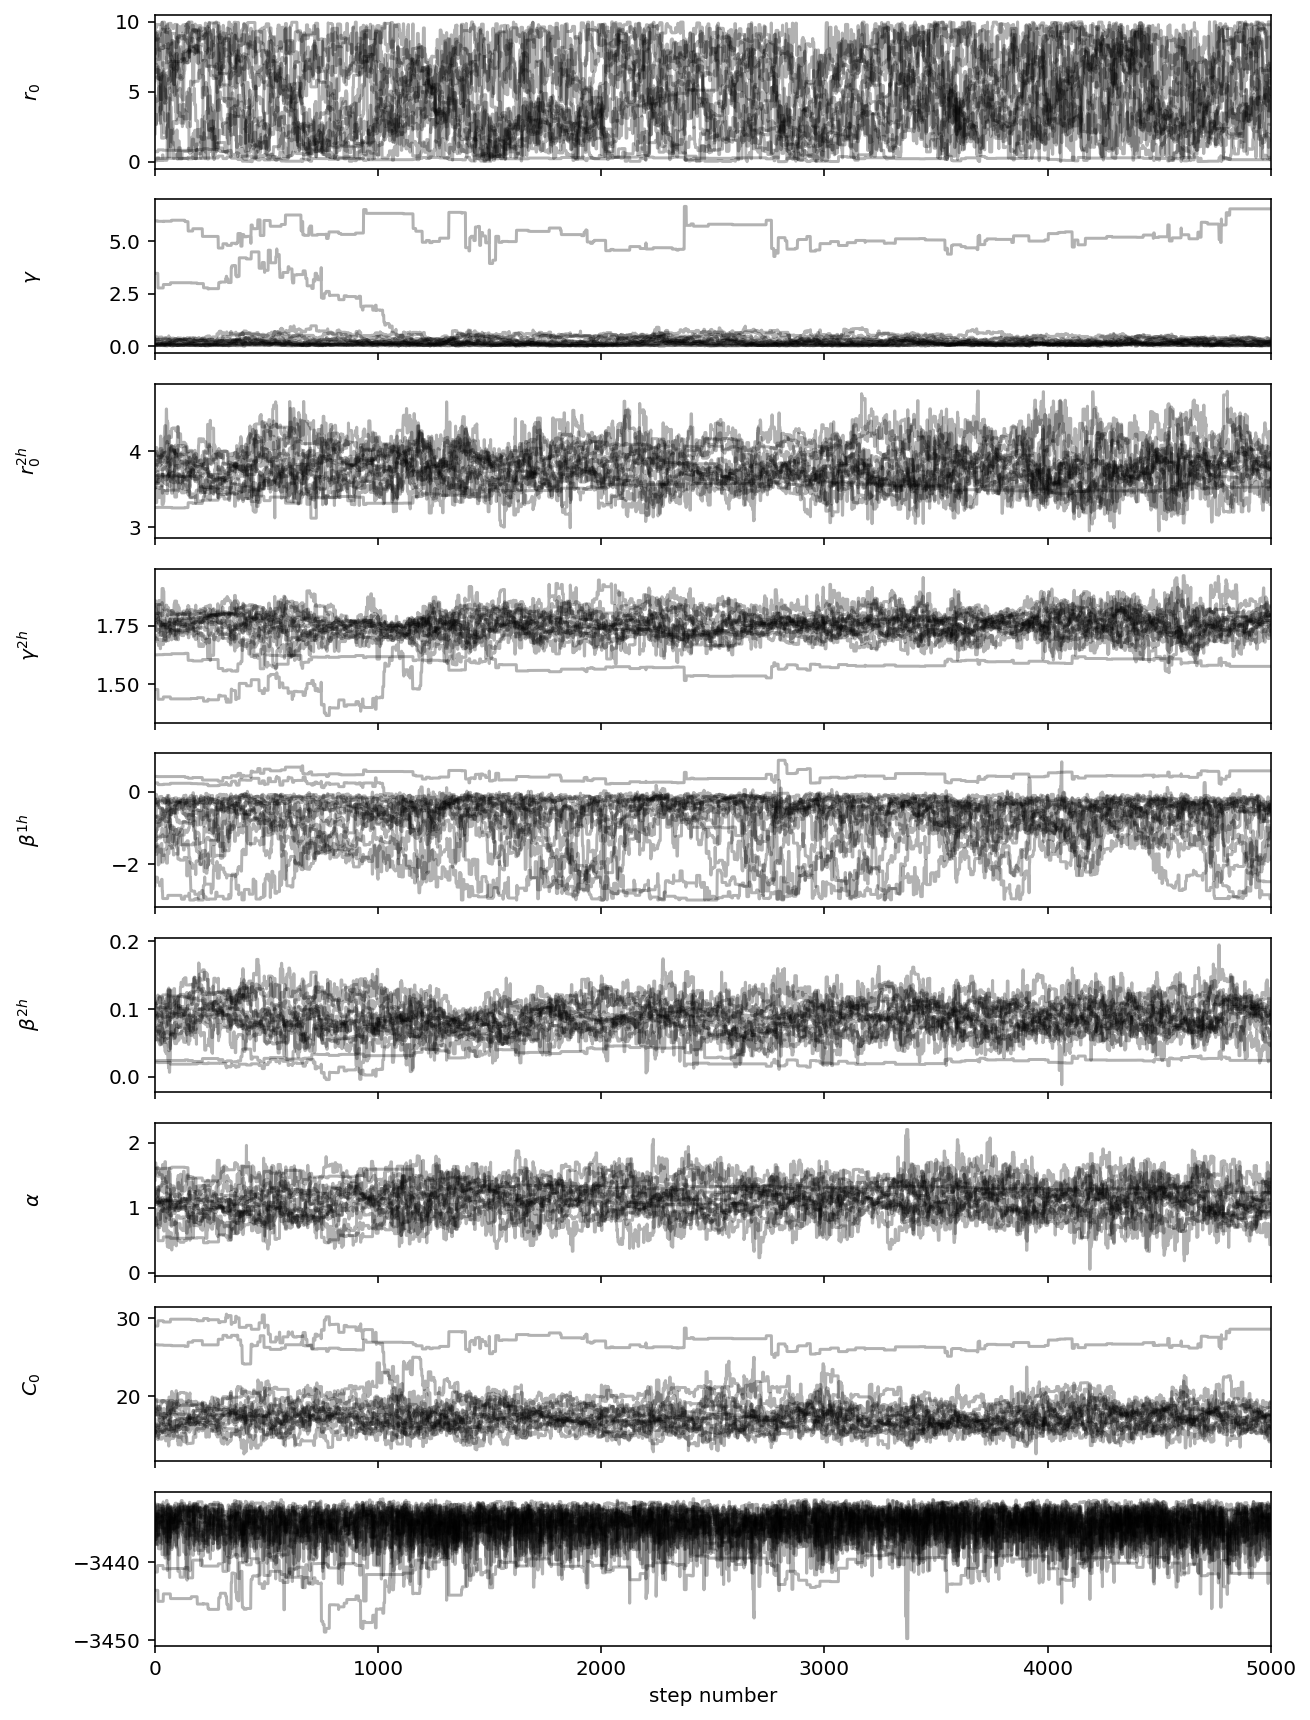

In [18]:
discard = 5000
samples = sampler.get_chain(discard=discard)
flat_samples = sampler.get_chain(discard=discard, thin=1, flat=True)

ndim = samples.shape[2]

# plot
# r0, gamma, r0_2, gamma_2, beta1, beta2, beta2h, dndz_index, dndz_coeff
fig, axes = plt.subplots(nrows=ndim+1, figsize=(10, 15), sharex=True)
labels = [r"$r_{0}$", r"$\gamma$", r"$r_0^{2h}$", r"$\gamma^{2h}$", r"$\beta^{1h}$", r"$\beta^{2h}$", r"$\alpha$", r'$C_0$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

axes[-1].plot(sampler.lnprobability.T[discard:], "k", alpha=0.3);

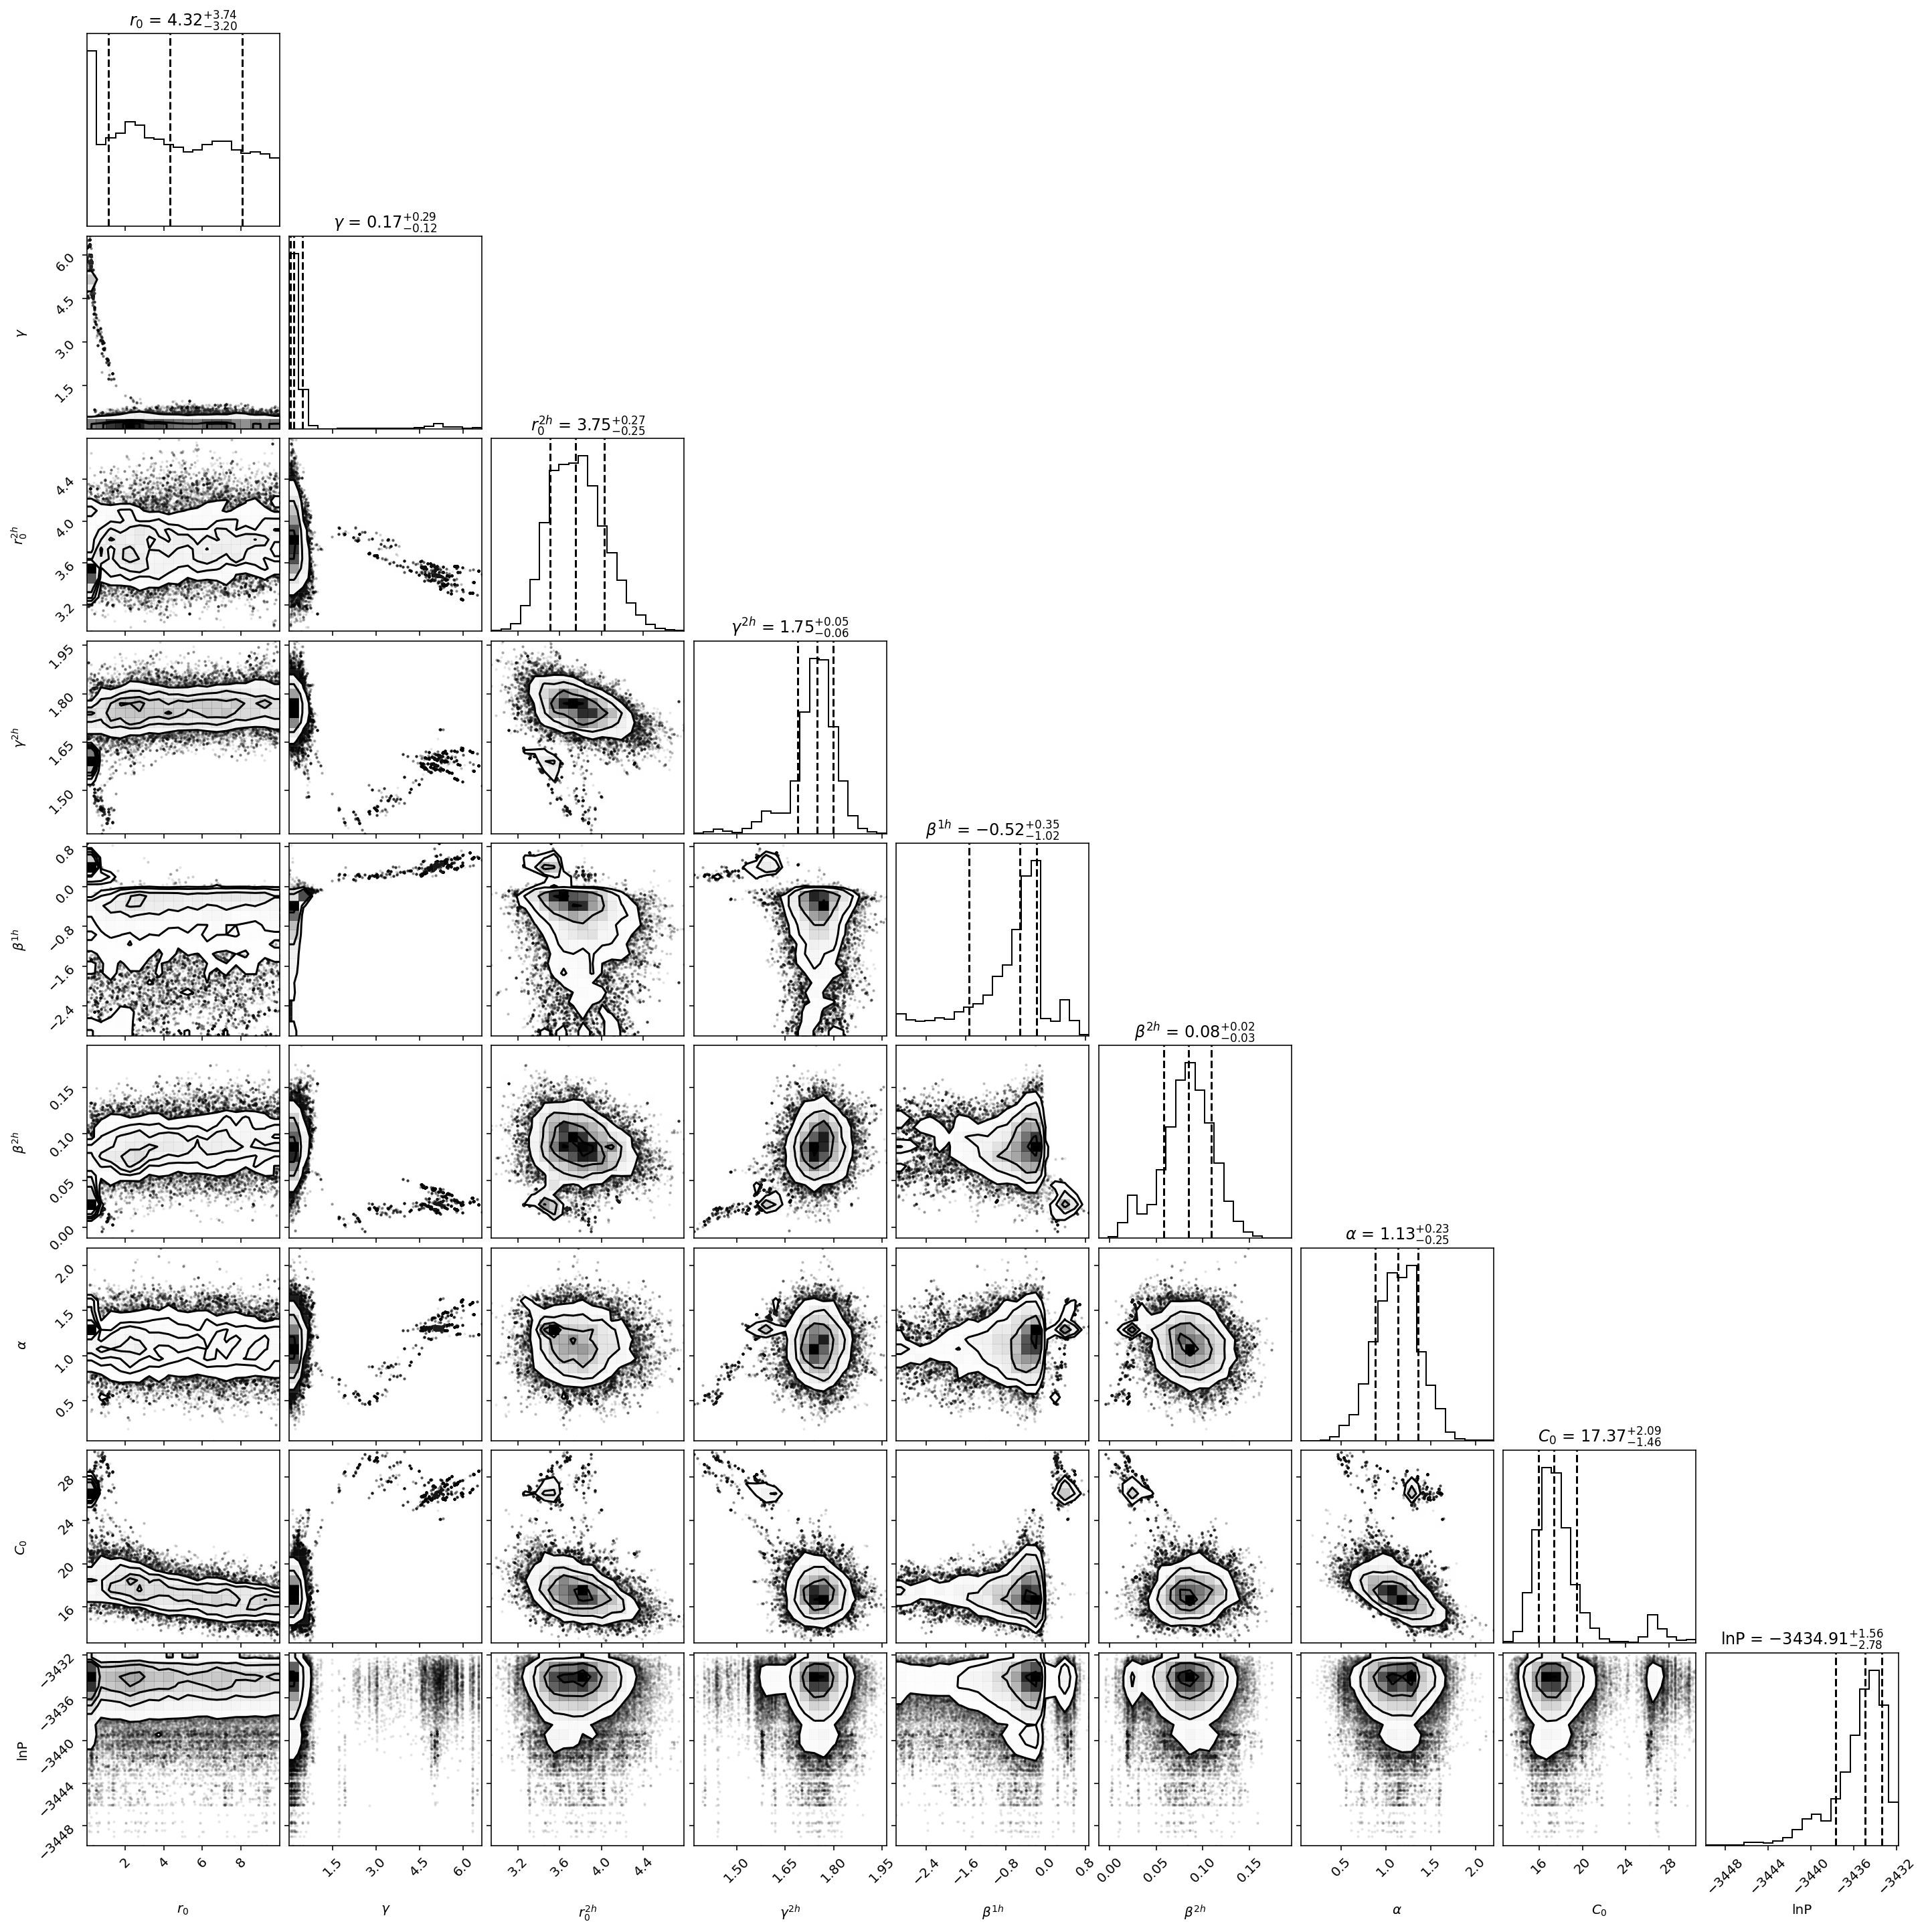

In [19]:
lnprob = sampler.lnprobability[:,discard:].ravel()
flt_w_likelihood = np.concatenate([flat_samples, lnprob[:, None]], axis=1)
fig = corner.corner(
    flt_w_likelihood, labels=labels+['lnP'], quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12}
);

(0.0, 4.0)

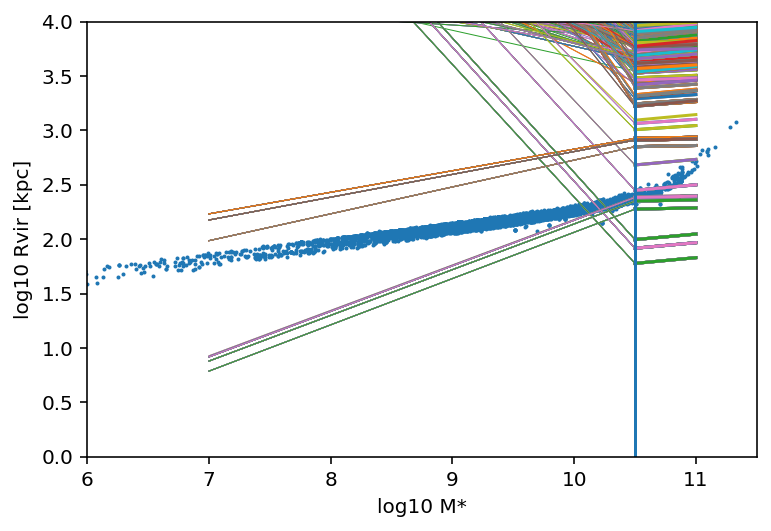

In [20]:
plt.scatter(np.log10(data[2]), np.log10(data[7]),s=1)
# plt.axline((9, 2), slope=1/8)
# plt.axline((9, 2), slope=0.5) # beta1h 1 
# plt.axline((10.5, 2.5), slope=0.05) # beta 1h 2
mline_lo = np.logspace(7,10.5)
mline_hi = np.logspace(10.5,11)

def rline(r0, beta, mline):
    m0 = 10**10.5
    return np.log10(r0*(mline/m0)**beta) + 3

asample = flat_samples[:1000].T
r0sample = asample[0]
beta1sample = asample[4]
beta2sample = asample[5]
plt.plot(np.log10(mline_lo), rline(r0sample, beta1sample, mline_lo[:, None]), lw=0.5)
plt.plot(np.log10(mline_hi), rline(r0sample, beta2sample, mline_hi[:, None]))

plt.axvline(10.5)
plt.xlabel("log10 M*")
plt.ylabel("log10 Rvir [kpc]")
plt.xlim(6, 11.5)
plt.ylim(0,4)